<a href="https://colab.research.google.com/github/luhoan/sin-karkinos/blob/main/FEW_SHOT_Cancer_Classification_via_Fine_Tuning_a_Vision_Transformer_with_Grad_CAM_for_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Access the shared dataset directory in our shared Google Drive file (*You have to add the file as a shortcut in your own drive for this to work*). Then initialize different labeled tumor folders as a dictionary for easy access to paths. Finally, append '/x_tumor' to the dataset paths to access the directory for each tumor group.

Now, after we've made our data accessible, we have to split our data. We're going to use a 70/15/15 split where 70% of the data is used for learning and 30% of the data is used to test and validate our model. We will split the dataset with Sci-kit just how we've learned in class.

In [ ]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import SegformerForImageClassification, SegformerFeatureExtractor
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset/Preprocessed'

tumor_paths = {
    'glioma_tumor': os.path.join(dataset_path, 'glioma_tumor'),
    'meningioma_tumor': os.path.join(dataset_path, 'meningioma_tumor'),
    'no_tumor': os.path.join(dataset_path, 'no_tumor'),
    'pituitary_tumor': os.path.join(dataset_path, 'pituitary_tumor')
}

for label, path in tumor_paths.items():
    print(f"{label}: {len(os.listdir(path))} images")
print(os.listdir('/content/drive/MyDrive/Dataset/Data'))

glioma_tumor: 926 images
meningioma_tumor: 937 images
no_tumor: 500 images
pituitary_tumor: 901 images
['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [ ]:
import glob
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

for label, folder_path in tumor_paths.items():
    for img_path in glob.glob(os.path.join(folder_path, '*')):
        image_paths.append(img_path)
        labels.append(label)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,test_size=0.50,stratify=temp_labels,
    random_state=42
)

print(f"Train: {len(train_paths)}")
print(f"Validation: {len(val_paths)}")
print(f"Test: {len(test_paths)}")

Train: 2284
Validation: 490
Test: 490


In [ ]:
def load_data(paths, labels):
    data = []
    targets = []

    for path, label in zip(paths, labels):
        img = torch.load(path)      # Load saved tensor image
        data.append(img)            # Append image to list
        targets.append(label)       # Append label to list

    return torch.stack(data), torch.tensor(targets)

In [ ]:
# label mapping
label_to_idx = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}

# Convert string labels to integers for each split
train_labels_int = [label_to_idx[label] for label in train_labels]
val_labels_int = [label_to_idx[label] for label in val_labels]
test_labels_int = [label_to_idx[label] for label in test_labels]

In [ ]:
class TumorDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = torch.load(self.paths[idx])  # Lazy loading
        y = self.labels[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

batch_size = 32

train_dataset = TumorDataset(train_paths, train_labels_int)
val_dataset = TumorDataset(val_paths, val_labels_int)
test_dataset = TumorDataset(test_paths, test_labels_int)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# This is just to make sure whatever is ran above actually worked.
print(f"Train: {len(train_paths)} images")
print(f"Val:   {len(val_paths)} images")
print(f"Test:  {len(test_paths)} images")

print("Example label:", train_labels[0], "→", train_labels_int[0])
print("Example path:", train_paths[0])

Train: 2284 images
Val:   490 images
Test:  490 images
Example label: pituitary_tumor → 3
Example path: /content/drive/MyDrive/Dataset/Preprocessed/pituitary_tumor/p (591).pt


In [ ]:
# BLOCK 6 ---------------------------------------------------------------------------

# from transformers import SegformerForImageClassification, SegformerFeatureExtractor
# import torch.nn.functional as F
# import torch.optim as optim
# from torch import nn

# # Load Segformer model and feature extractor
# model_name = 'nvidia/segformer-b0-finetuned-ade-512-512'
# model = SegformerForImageClassification.from_pretrained(model_name, num_labels=4)
# feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# # Move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define optimizer and loss function
# optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# num_epochs = 10
# model.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   

In [ ]:
# DO NOT RE-RUN THE TRAINING 🥺

from transformers import SegformerForImageClassification, SegformerFeatureExtractor
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tqdm import tqdm

num_epochs = 10

# Few-shot percentages to try
few_shot_sizes = [0.1, 0.2, 0.3, 0.5, 1.0]

for few_shot_size in few_shot_sizes:
    print(f"\n{'='*50}")
    print(f"Running few-shot training with {int(few_shot_size*100)}% of training data")
    print(f"{'='*50}\n")

    if few_shot_size < 1.0:
        # Subset training set
        train_paths_fs, _, train_labels_fs, _ = train_test_split(
            train_paths, train_labels_int,
            test_size=1 - few_shot_size,
            stratify=train_labels_int,
            random_state=42
        )
    else:
        # Use full dataset
        train_paths_fs, train_labels_fs = train_paths, train_labels_int

    # Build few-shot dataset/loader
    train_dataset_fs = TumorDataset(train_paths_fs, train_labels_fs)
    train_loader_fs = DataLoader(train_dataset_fs, batch_size=batch_size, shuffle=True, num_workers=2)

    # Fresh model + optimizer per run
    model = SegformerForImageClassification.from_pretrained(
        'nvidia/segformer-b0-finetuned-ade-512-512',
        num_labels=4
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    criterion = nn.CrossEntropyLoss()

    # Save dir for this percentage
    output_dir = f"/content/drive/MyDrive/Dataset/few_shot/{int(few_shot_size*100)}%"
    os.makedirs(output_dir, exist_ok=True)
    best_model_path = os.path.join(output_dir, "SegFormer_FewShot.pth")

    best_val_acc = 0.0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader_fs, desc=f"[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader_fs)
        epoch_acc = accuracy_score(all_labels, all_preds)
        print(f"\n[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss, val_preds, val_labels_all = 0.0, [], []
        with torch.no_grad():
            for batch in val_loader:
                val_inputs, val_labels_batch = batch
                val_inputs, val_labels_batch = val_inputs.to(device), val_labels_batch.to(device)

                outputs = model(val_inputs)
                logits = outputs.logits
                loss = criterion(logits, val_labels_batch)

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_all.extend(val_labels_batch.cpu().numpy())

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels_all, val_preds)
        print(f"[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Best {int(few_shot_size*100)}% model saved with Val Accuracy: {best_val_acc:.4f}\n")

    print(f"Finished training {int(few_shot_size*100)}% few-shot model.\n")


Running few-shot training with 10% of training data



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[10%] Epoch 1/10: 100%|██████████| 8/8 [01:26<00:00, 10.77s/it]


[10%] Epoch 1/10 - Train Loss: 1.2225, Train Accuracy: 0.4035


[10%] Epoch 1/10 - Val Loss: 0.9642, Val Accuracy: 0.6143
Best 10% model saved with Val Accuracy: 0.6143



[10%] Epoch 2/10: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


[10%] Epoch 2/10 - Train Loss: 0.8247, Train Accuracy: 0.6886


[10%] Epoch 2/10 - Val Loss: 0.8205, Val Accuracy: 0.6653
Best 10% model saved with Val Accuracy: 0.6653



[10%] Epoch 3/10: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


[10%] Epoch 3/10 - Train Loss: 0.6589, Train Accuracy: 0.7193


[10%] Epoch 3/10 - Val Loss: 0.6736, Val Accuracy: 0.6898
Best 10% model saved with Val Accuracy: 0.6898



[10%] Epoch 4/10: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


[10%] Epoch 4/10 - Train Loss: 0.5896, Train Accuracy: 0.7632


[10%] Epoch 4/10 - Val Loss: 0.5823, Val Accuracy: 0.7653
Best 10% model saved with Val Accuracy: 0.7653



[10%] Epoch 5/10: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


[10%] Epoch 5/10 - Train Loss: 0.4935, Train Accuracy: 0.8158


[10%] Epoch 5/10 - Val Loss: 0.5389, Val Accuracy: 0.7653


[10%] Epoch 6/10: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


[10%] Epoch 6/10 - Train Loss: 0.4267, Train Accuracy: 0.8509


[10%] Epoch 6/10 - Val Loss: 0.5775, Val Accuracy: 0.7694
Best 10% model saved with Val Accuracy: 0.7694



[10%] Epoch 7/10: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


[10%] Epoch 7/10 - Train Loss: 0.4412, Train Accuracy: 0.8596


[10%] Epoch 7/10 - Val Loss: 0.5253, Val Accuracy: 0.7837
Best 10% model saved with Val Accuracy: 0.7837



[10%] Epoch 8/10: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


[10%] Epoch 8/10 - Train Loss: 0.3631, Train Accuracy: 0.8640


[10%] Epoch 8/10 - Val Loss: 0.5395, Val Accuracy: 0.7939
Best 10% model saved with Val Accuracy: 0.7939



[10%] Epoch 9/10: 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


[10%] Epoch 9/10 - Train Loss: 0.2855, Train Accuracy: 0.8904


[10%] Epoch 9/10 - Val Loss: 0.5754, Val Accuracy: 0.7980
Best 10% model saved with Val Accuracy: 0.7980



[10%] Epoch 10/10: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


[10%] Epoch 10/10 - Train Loss: 0.2291, Train Accuracy: 0.9079


[10%] Epoch 10/10 - Val Loss: 0.5905, Val Accuracy: 0.7714
Finished training 10% few-shot model.


Running few-shot training with 20% of training data



Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[20%] Epoch 1/10: 100%|██████████| 15/15 [01:01<00:00,  4.09s/it]


[20%] Epoch 1/10 - Train Loss: 1.2608, Train Accuracy: 0.4496


[20%] Epoch 1/10 - Val Loss: 0.9842, Val Accuracy: 0.6102
Best 20% model saved with Val Accuracy: 0.6102



[20%] Epoch 2/10: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


[20%] Epoch 2/10 - Train Loss: 0.8545, Train Accuracy: 0.6557


[20%] Epoch 2/10 - Val Loss: 0.6579, Val Accuracy: 0.7510
Best 20% model saved with Val Accuracy: 0.7510



[20%] Epoch 3/10: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


[20%] Epoch 3/10 - Train Loss: 0.6586, Train Accuracy: 0.7500


[20%] Epoch 3/10 - Val Loss: 0.5231, Val Accuracy: 0.8143
Best 20% model saved with Val Accuracy: 0.8143



[20%] Epoch 4/10: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


[20%] Epoch 4/10 - Train Loss: 0.5034, Train Accuracy: 0.7807


[20%] Epoch 4/10 - Val Loss: 0.4856, Val Accuracy: 0.8408
Best 20% model saved with Val Accuracy: 0.8408



[20%] Epoch 5/10: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


[20%] Epoch 5/10 - Train Loss: 0.4251, Train Accuracy: 0.8355


[20%] Epoch 5/10 - Val Loss: 0.4797, Val Accuracy: 0.8408


[20%] Epoch 6/10: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


[20%] Epoch 6/10 - Train Loss: 0.3530, Train Accuracy: 0.8816


[20%] Epoch 6/10 - Val Loss: 0.4394, Val Accuracy: 0.8327


[20%] Epoch 7/10: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


[20%] Epoch 7/10 - Train Loss: 0.3061, Train Accuracy: 0.8925


[20%] Epoch 7/10 - Val Loss: 0.4208, Val Accuracy: 0.8265


[20%] Epoch 8/10: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]



[20%] Epoch 8/10 - Train Loss: 0.2453, Train Accuracy: 0.9035
[20%] Epoch 8/10 - Val Loss: 0.3976, Val Accuracy: 0.8306


[20%] Epoch 9/10: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


[20%] Epoch 9/10 - Train Loss: 0.1995, Train Accuracy: 0.9254


[20%] Epoch 9/10 - Val Loss: 0.4298, Val Accuracy: 0.8286


[20%] Epoch 10/10: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]



[20%] Epoch 10/10 - Train Loss: 0.1582, Train Accuracy: 0.9452
[20%] Epoch 10/10 - Val Loss: 0.3964, Val Accuracy: 0.8490
Best 20% model saved with Val Accuracy: 0.8490

Finished training 20% few-shot model.


Running few-shot training with 30% of training data



Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[30%] Epoch 1/10: 100%|██████████| 22/22 [01:06<00:00,  3.01s/it]


[30%] Epoch 1/10 - Train Loss: 1.1506, Train Accuracy: 0.4934


[30%] Epoch 1/10 - Val Loss: 0.7563, Val Accuracy: 0.6878
Best 30% model saved with Val Accuracy: 0.6878



[30%] Epoch 2/10: 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


[30%] Epoch 2/10 - Train Loss: 0.6724, Train Accuracy: 0.7372


[30%] Epoch 2/10 - Val Loss: 0.5979, Val Accuracy: 0.7673
Best 30% model saved with Val Accuracy: 0.7673



[30%] Epoch 3/10: 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


[30%] Epoch 3/10 - Train Loss: 0.5724, Train Accuracy: 0.7825


[30%] Epoch 3/10 - Val Loss: 0.4843, Val Accuracy: 0.8041
Best 30% model saved with Val Accuracy: 0.8041



[30%] Epoch 4/10: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


[30%] Epoch 4/10 - Train Loss: 0.4209, Train Accuracy: 0.8482


[30%] Epoch 4/10 - Val Loss: 0.4440, Val Accuracy: 0.8265
Best 30% model saved with Val Accuracy: 0.8265



[30%] Epoch 5/10: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


[30%] Epoch 5/10 - Train Loss: 0.3483, Train Accuracy: 0.8730


[30%] Epoch 5/10 - Val Loss: 0.4065, Val Accuracy: 0.8347
Best 30% model saved with Val Accuracy: 0.8347



[30%] Epoch 6/10: 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


[30%] Epoch 6/10 - Train Loss: 0.2737, Train Accuracy: 0.9036


[30%] Epoch 6/10 - Val Loss: 0.3689, Val Accuracy: 0.8694
Best 30% model saved with Val Accuracy: 0.8694



[30%] Epoch 7/10: 100%|██████████| 22/22 [00:14<00:00,  1.54it/s]


[30%] Epoch 7/10 - Train Loss: 0.2126, Train Accuracy: 0.9343


[30%] Epoch 7/10 - Val Loss: 0.3346, Val Accuracy: 0.8694


[30%] Epoch 8/10: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s]


[30%] Epoch 8/10 - Train Loss: 0.1804, Train Accuracy: 0.9416


[30%] Epoch 8/10 - Val Loss: 0.3406, Val Accuracy: 0.8939
Best 30% model saved with Val Accuracy: 0.8939



[30%] Epoch 9/10: 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


[30%] Epoch 9/10 - Train Loss: 0.1340, Train Accuracy: 0.9547


[30%] Epoch 9/10 - Val Loss: 0.4285, Val Accuracy: 0.8551


[30%] Epoch 10/10: 100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


[30%] Epoch 10/10 - Train Loss: 0.1405, Train Accuracy: 0.9518


[30%] Epoch 10/10 - Val Loss: 0.4009, Val Accuracy: 0.8571
Finished training 30% few-shot model.


Running few-shot training with 50% of training data



Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[50%] Epoch 1/10: 100%|██████████| 36/36 [02:02<00:00,  3.39s/it]


[50%] Epoch 1/10 - Train Loss: 0.9488, Train Accuracy: 0.6042


[50%] Epoch 1/10 - Val Loss: 0.5205, Val Accuracy: 0.8122
Best 50% model saved with Val Accuracy: 0.8122



[50%] Epoch 2/10: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


[50%] Epoch 2/10 - Train Loss: 0.5398, Train Accuracy: 0.7925


[50%] Epoch 2/10 - Val Loss: 0.4575, Val Accuracy: 0.8347
Best 50% model saved with Val Accuracy: 0.8347



[50%] Epoch 3/10: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


[50%] Epoch 3/10 - Train Loss: 0.4047, Train Accuracy: 0.8503


[50%] Epoch 3/10 - Val Loss: 0.4447, Val Accuracy: 0.8102


[50%] Epoch 4/10: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


[50%] Epoch 4/10 - Train Loss: 0.3159, Train Accuracy: 0.8774


[50%] Epoch 4/10 - Val Loss: 0.3737, Val Accuracy: 0.8531
Best 50% model saved with Val Accuracy: 0.8531



[50%] Epoch 5/10: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


[50%] Epoch 5/10 - Train Loss: 0.2277, Train Accuracy: 0.9247


[50%] Epoch 5/10 - Val Loss: 0.3136, Val Accuracy: 0.8959
Best 50% model saved with Val Accuracy: 0.8959



[50%] Epoch 6/10: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


[50%] Epoch 6/10 - Train Loss: 0.1946, Train Accuracy: 0.9343


[50%] Epoch 6/10 - Val Loss: 0.2647, Val Accuracy: 0.9122
Best 50% model saved with Val Accuracy: 0.9122



[50%] Epoch 7/10: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


[50%] Epoch 7/10 - Train Loss: 0.1374, Train Accuracy: 0.9580


[50%] Epoch 7/10 - Val Loss: 0.1965, Val Accuracy: 0.9306
Best 50% model saved with Val Accuracy: 0.9306



[50%] Epoch 8/10: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


[50%] Epoch 8/10 - Train Loss: 0.1022, Train Accuracy: 0.9694


[50%] Epoch 8/10 - Val Loss: 0.2617, Val Accuracy: 0.9163


[50%] Epoch 9/10: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


[50%] Epoch 9/10 - Train Loss: 0.0867, Train Accuracy: 0.9737


[50%] Epoch 9/10 - Val Loss: 0.1904, Val Accuracy: 0.9306


[50%] Epoch 10/10: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


[50%] Epoch 10/10 - Train Loss: 0.0847, Train Accuracy: 0.9729


[50%] Epoch 10/10 - Val Loss: 0.2908, Val Accuracy: 0.9204
Finished training 50% few-shot model.


Running few-shot training with 100% of training data



InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 0.0 instead.

In [ ]:
from transformers import SegformerForImageClassification, SegformerFeatureExtractor
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tqdm import tqdm

num_epochs = 10

# Few-shot percentages to try
few_shot_sizes = [0.1, 0.2, 0.3, 0.5, 1.0]

# Re-run only the 100% training case
few_shot_size = 1.0
print(f"\n{'='*50}")
print(f"Running few-shot training with {int(few_shot_size*100)}% of training data")
print(f"{'='*50}\n")

# Use full dataset
train_paths_fs, train_labels_fs = train_paths, train_labels_int

# Build dataset/loader
train_dataset_fs = TumorDataset(train_paths_fs, train_labels_fs)
train_loader_fs = DataLoader(train_dataset_fs, batch_size=batch_size, shuffle=True, num_workers=0)

# Fresh model + optimizer
model = SegformerForImageClassification.from_pretrained(
    'nvidia/segformer-b0-finetuned-ade-512-512',
    num_labels=4
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Save dir
output_dir = f"/content/drive/MyDrive/Dataset/few_shot/100%"
os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, "SegFormer_FewShot.pth")

best_val_acc = 0.0

# Training loop (same as before)
for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader_fs, desc=f"[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader_fs)
        epoch_acc = accuracy_score(all_labels, all_preds)
        print(f"\n[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss, val_preds, val_labels_all = 0.0, [], []
        with torch.no_grad():
            for batch in val_loader:
                val_inputs, val_labels_batch = batch
                val_inputs, val_labels_batch = val_inputs.to(device), val_labels_batch.to(device)

                outputs = model(val_inputs)
                logits = outputs.logits
                loss = criterion(logits, val_labels_batch)

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_all.extend(val_labels_batch.cpu().numpy())

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels_all, val_preds)
        print(f"[{int(few_shot_size*100)}%] Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Best {int(few_shot_size*100)}% model saved with Val Accuracy: {best_val_acc:.4f}\n")

print(f"Finished training {int(few_shot_size*100)}% few-shot model.\n")


Running few-shot training with 100% of training data



Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[100%] Epoch 1/10: 100%|██████████| 72/72 [01:18<00:00,  1.09s/it]


[100%] Epoch 1/10 - Train Loss: 0.7552, Train Accuracy: 0.6931


[100%] Epoch 1/10 - Val Loss: 0.4409, Val Accuracy: 0.8551
Best 100% model saved with Val Accuracy: 0.8551



[100%] Epoch 2/10: 100%|██████████| 72/72 [01:18<00:00,  1.09s/it]


[100%] Epoch 2/10 - Train Loss: 0.3951, Train Accuracy: 0.8516


[100%] Epoch 2/10 - Val Loss: 0.2861, Val Accuracy: 0.9041
Best 100% model saved with Val Accuracy: 0.9041



[100%] Epoch 3/10: 100%|██████████| 72/72 [01:17<00:00,  1.07s/it]


[100%] Epoch 3/10 - Train Loss: 0.2499, Train Accuracy: 0.9129


[100%] Epoch 3/10 - Val Loss: 0.2043, Val Accuracy: 0.9367
Best 100% model saved with Val Accuracy: 0.9367



[100%] Epoch 4/10: 100%|██████████| 72/72 [01:16<00:00,  1.06s/it]


[100%] Epoch 4/10 - Train Loss: 0.1546, Train Accuracy: 0.9536


[100%] Epoch 4/10 - Val Loss: 0.3288, Val Accuracy: 0.8939


[100%] Epoch 5/10: 100%|██████████| 72/72 [01:16<00:00,  1.06s/it]


[100%] Epoch 5/10 - Train Loss: 0.1273, Train Accuracy: 0.9540


[100%] Epoch 5/10 - Val Loss: 0.1049, Val Accuracy: 0.9694
Best 100% model saved with Val Accuracy: 0.9694



[100%] Epoch 6/10: 100%|██████████| 72/72 [01:15<00:00,  1.05s/it]


[100%] Epoch 6/10 - Train Loss: 0.0977, Train Accuracy: 0.9676


[100%] Epoch 6/10 - Val Loss: 0.1331, Val Accuracy: 0.9571


[100%] Epoch 7/10: 100%|██████████| 72/72 [01:15<00:00,  1.04s/it]


[100%] Epoch 7/10 - Train Loss: 0.0760, Train Accuracy: 0.9755


[100%] Epoch 7/10 - Val Loss: 0.1261, Val Accuracy: 0.9653


[100%] Epoch 8/10: 100%|██████████| 72/72 [01:14<00:00,  1.04s/it]


[100%] Epoch 8/10 - Train Loss: 0.0533, Train Accuracy: 0.9829


[100%] Epoch 8/10 - Val Loss: 0.0996, Val Accuracy: 0.9694


[100%] Epoch 9/10: 100%|██████████| 72/72 [01:14<00:00,  1.03s/it]


[100%] Epoch 9/10 - Train Loss: 0.0385, Train Accuracy: 0.9882


[100%] Epoch 9/10 - Val Loss: 0.1357, Val Accuracy: 0.9531


[100%] Epoch 10/10: 100%|██████████| 72/72 [01:14<00:00,  1.03s/it]


[100%] Epoch 10/10 - Train Loss: 0.0554, Train Accuracy: 0.9825


[100%] Epoch 10/10 - Val Loss: 0.1281, Val Accuracy: 0.9633
Finished training 100% few-shot model.



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import SegformerForImageClassification
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO

# helper functions to try to fix visualizations

def clean_restart():
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("cleaned cached modules and memory")

def visualize_attention(attention_map, original_image, invert_colormap=False):
    if attention_map is None:
        print("No attention map to visualize")
        return None, None, None

    try:
        if isinstance(original_image, torch.Tensor):
            if original_image.dim() == 4:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = original_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
                img_np = std * img_np + mean
            else:
                img_np = original_image.permute(1, 2, 0).cpu().detach().numpy()
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = np.array(original_image)

        # Get original image dimensions
        h, w = img_np.shape[:2]

        # Select colormap
        colormap = 'jet_r' if invert_colormap else 'jet'

        # Resize attention map to match input image
        attn_resized = cv2.resize(attention_map, (w, h), interpolation=cv2.INTER_LINEAR)
        attn_normalized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)

        # Apply colormap to RESIZED attention map
        heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[..., :3]
        overlay = 0.6 * img_np + 0.4 * heatmap
        overlay = np.clip(overlay, 0, 1)

        return img_np, heatmap, overlay

    except Exception as e:
        print(f"Visualization error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def visualize_segformer_attention(model, input_tensor, invert_colormap=False):
    print("visualizing attention")

    attention_outputs = []

    # Hook the attention output dense layer of the last block
    last_block_attention_output = model.segformer.encoder.block[3][1].attention.output.dense

    def hook_fn(module, input, output):
        attention_outputs.append(output.detach())

    hook = last_block_attention_output.register_forward_hook(hook_fn)

    try:
        print("forward pass to capture attention")
        with torch.no_grad():
            _ = model(input_tensor)

        if not attention_outputs:
            print("Hook didn't get any output")
            return None

        attention_output = attention_outputs[0]
        print(f"hook captured attention output with shape: {attention_output.shape}")

        # Process attention output
        attention_output = attention_output.squeeze(0)  # Remove batch dimension
        attention_map = attention_output.mean(dim=-1).cpu().numpy()  # Average over channels

        # Reshape to 2D grid (assuming square patches)
        num_patches = attention_map.shape[0]
        patch_size = int(np.sqrt(num_patches))
        if patch_size * patch_size == num_patches:
            attention_map_2d = attention_map.reshape(patch_size, patch_size)
            print(f"Reshaped attention map to 2D grid: {attention_map_2d.shape}")
        else:
            print(f"Can't reshape {num_patches} patches to square grid, using flattened version")
            attention_map_2d = attention_map

        return attention_map_2d

    except Exception as e:
        print(f"Error in attention visualization: {e}")
        return None

    finally:
        hook.remove()
        print("Hook removed.")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Few-shot percentages to try
few_shot_sizes = [0.1, 0.2, 0.3, 0.5, 1.0]

# Always use the same MRI tensor for clarity
try:
    image_tensor_path = "/content/drive/MyDrive/Dataset/Preprocessed/meningioma_tumor/Copy of image(2).pt"
    original_tensor = torch.load(image_tensor_path, map_location=device)
    if original_tensor.dim() == 3:
        original_tensor = original_tensor.unsqueeze(0)
    input_tensor = original_tensor.to(device)
    print(f"Loaded input tensor with shape: {input_tensor.shape}")
except FileNotFoundError:
    print(f"Tensor not found at {image_tensor_path}; using random input as fallback.")
    input_tensor = torch.randn(1, 3, 512, 512).to(device)

# --- loop over all percentages ---
for few_shot_size in few_shot_sizes:
    percentage_label = f"{int(few_shot_size*100)}%"
    output_dir = f"/content/drive/MyDrive/Dataset/few_shot/{percentage_label}"
    best_model_path = os.path.join(output_dir, "SegFormer_FewShot.pth")

    print(f"Processing {percentage_label} few-shot model")

    # Check if model exists
    if not os.path.exists(best_model_path):
        print(f"Model not found at {best_model_path}. Skipping {percentage_label}.")
        continue

    # Clean memory before loading new model
    clean_restart()

    try:
        # Load model architecture for this percentage
        model = SegformerForImageClassification.from_pretrained(
            'nvidia/segformer-b0-finetuned-ade-512-512',
            num_labels=4
        ).to(device)

        # Load trained weights
        model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu'))) # When using gpu, change to 'map_location=device'
        model.eval()
        print(f"Successfully loaded model for {percentage_label}")

    except Exception as e:
        print(f"Error loading model for {percentage_label}: {e}")
        continue

    # Create heatmap folder inside percentage folder
    os.makedirs(output_dir, exist_ok=True)
    heatmap_dir = os.path.join(output_dir, "heatmaps")
    os.makedirs(heatmap_dir, exist_ok=True)

    """ this is being weird
    print(f"Generating attention heatmaps for {int(few_shot_size*100)}% few-shot model...")

    clean_restart()

    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f"mri_run_{run_id}"
    """

    # Generate attention map
    attention_map = visualize_segformer_attention(
        model,
        input_tensor,
        invert_colormap=True
    )

    if attention_map is not None:
        # Convert to visual outputs
        orig_img, heatmap, overlay = visualize_attention(
            attention_map,
            input_tensor,
            invert_colormap=True
        )

        if orig_img is not None:
            # Plot side-by-side
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Original Image
            axes[0].imshow(orig_img)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            # Heatmap
            axes[1].imshow(heatmap, cmap="jet_r")
            axes[1].set_title("Attention Heatmap")
            axes[1].axis("off")

            # Overlay
            axes[2].imshow(overlay)
            axes[2].set_title("Attention Overlay")
            axes[2].axis("off")

            plt.tight_layout()

            # Save figure
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_path = os.path.join(output_dir, f"attention_heatmap_{timestamp}.png")
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Saved attention visualization to: {output_path}")

            # # Also save individual components in heatmaps folder
            # plt.imsave(os.path.join(heatmap_dir, f"original_{timestamp}.png"), orig_img)
            # plt.imsave(os.path.join(heatmap_dir, f"heatmap_{timestamp}.png"), heatmap)
            # plt.imsave(os.path.join(heatmap_dir, f"overlay_{timestamp}.png"), overlay)
            # print(f"Saved individual components to heatmaps folder")
        else:
            print("Failed to generate visualization components")
    else:
        print("Failed to generate attention map")

        """
        # Convert tensors to numpy for plotting
        orig_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        heatmap = attention_map

        # Normalize heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Make overlay
        cmap = plt.get_cmap("jet_r")
        heatmap_color = cmap(heatmap)[..., :3]
        overlay = (0.6 * orig_img + 0.4 * heatmap_color)
        overlay = np.clip(overlay, 0, 1)
        """
        # # Plot side-by-side
        # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        # axes[0].imshow(orig_img)
        # axes[0].set_title("Original Image")
        # axes[0].axis("off")

        # axes[1].imshow(heatmap, cmap="jet_r")
        # axes[1].set_title("Attention Heatmap")
        # axes[1].axis("off")

        # axes[2].imshow(overlay)
        # axes[2].set_title("Overlay")
        # axes[2].axis("off")

        # plt.tight_layout()
        # plt.savefig(os.path.join(percent_folder, f"attention_{int(few_shot_size*100)}.png"))
        # plt.close()
        # print(f"Saved attention figure to {percent_folder}")

    # Evaluate on test set
    test_preds, test_labels_all = [], []
    with torch.no_grad():
        for batch in test_loader:
            test_inputs, test_labels_batch = batch
            test_inputs = test_inputs.to(device)
            test_labels_batch = test_labels_batch.to(device)

            outputs = model(test_inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels_all.extend(test_labels_batch.cpu().numpy())

    # Save classification report
    report = classification_report(
        test_labels_all,
        test_preds,
        target_names=list(label_to_idx.keys()),
        output_dict=True
    )
    report_path = os.path.join(output_dir, "classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)

    # Save confusion matrix
    cm = confusion_matrix(test_labels_all, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=label_to_idx.keys(),
                yticklabels=label_to_idx.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {int(few_shot_size*100)}% Few-Shot")
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
    plt.close()

    print(f"Classification report + confusion matrix saved for {int(few_shot_size*100)}% few-shot model.")

Using device: cpu
✅ Loaded input tensor with shape: torch.Size([1, 3, 380, 380])

Processing 10% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 10%
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)
Hook removed.


/tmp/ipython-input-424757971.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


✅ Saved attention visualization to: /content/drive/MyDrive/Dataset/few_shot/10%/attention_heatmap_20250928_192707.png
📊 Classification report + confusion matrix saved for 10% few-shot model.

Processing 20% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 20%
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)
Hook removed.


/tmp/ipython-input-424757971.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


✅ Saved attention visualization to: /content/drive/MyDrive/Dataset/few_shot/20%/attention_heatmap_20250928_192834.png
📊 Classification report + confusion matrix saved for 20% few-shot model.

Processing 30% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 30%
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)
Hook removed.


/tmp/ipython-input-424757971.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


✅ Saved attention visualization to: /content/drive/MyDrive/Dataset/few_shot/30%/attention_heatmap_20250928_193000.png
📊 Classification report + confusion matrix saved for 30% few-shot model.

Processing 50% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 50%
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)
Hook removed.


/tmp/ipython-input-424757971.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


✅ Saved attention visualization to: /content/drive/MyDrive/Dataset/few_shot/50%/attention_heatmap_20250928_193102.png
📊 Classification report + confusion matrix saved for 50% few-shot model.

Processing 100% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 100%
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)
Hook removed.


/tmp/ipython-input-424757971.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


✅ Saved attention visualization to: /content/drive/MyDrive/Dataset/few_shot/100%/attention_heatmap_20250928_193204.png
📊 Classification report + confusion matrix saved for 100% few-shot model.


In [ ]:
# --- loop over all percentages ---
few_shot_sizes = [0.1, 0.2, 0.3, 0.5, 1.0]

for few_shot_size in few_shot_sizes:
    percentage_label = f"{int(few_shot_size*100)}%"
    output_dir = f"/content/drive/MyDrive/Dataset/few_shot/{percentage_label}"
    best_model_path = os.path.join(output_dir, "SegFormer_FewShot.pth")

    print(f"Processing {percentage_label} few-shot model")

    # Check if model exists
    if not os.path.exists(best_model_path):
        print(f"Model not found at {best_model_path}. Skipping {percentage_label}.")
        continue

    # Clean memory before loading new model
    clean_restart()

try:
    # Load model architecture for this percentage
    model = SegformerForImageClassification.from_pretrained(
        'nvidia/segformer-b0-finetuned-ade-512-512',
        num_labels=4
    ).to(device)

    # Load trained weights
    model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu'))) # When using gpu, change to 'map_location=device'
    model.eval()
    print(f"successfully loaded model for {percentage_label}")

except Exception as e:
    print(f"Error loading model for {percentage_label}: {e}")


Processing 10% few-shot model
✅ Cleaned all cached modules and memory

Processing 20% few-shot model
✅ Cleaned all cached modules and memory

Processing 30% few-shot model
✅ Cleaned all cached modules and memory

Processing 50% few-shot model
✅ Cleaned all cached modules and memory

Processing 100% few-shot model
✅ Cleaned all cached modules and memory


Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Successfully loaded model for 100%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Evaluate on test set
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        test_inputs, test_labels_batch = batch
        test_inputs = test_inputs.to(device)
        test_labels_batch = test_labels_batch.to(device)

        outputs = model(test_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels_all.extend(test_labels_batch.cpu().numpy())

# Save confusion matrix
cm = confusion_matrix(test_labels_all, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=label_to_idx.keys(),
            yticklabels=label_to_idx.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {int(few_shot_size*100)}% Few-Shot")
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.close()

print(f"Classification report + confusion matrix saved for {int(few_shot_size*100)}% few-shot model.")

Classification report + confusion matrix saved for 100% few-shot model.


In [ ]:
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

NameError: name 'train_accuracy' is not defined

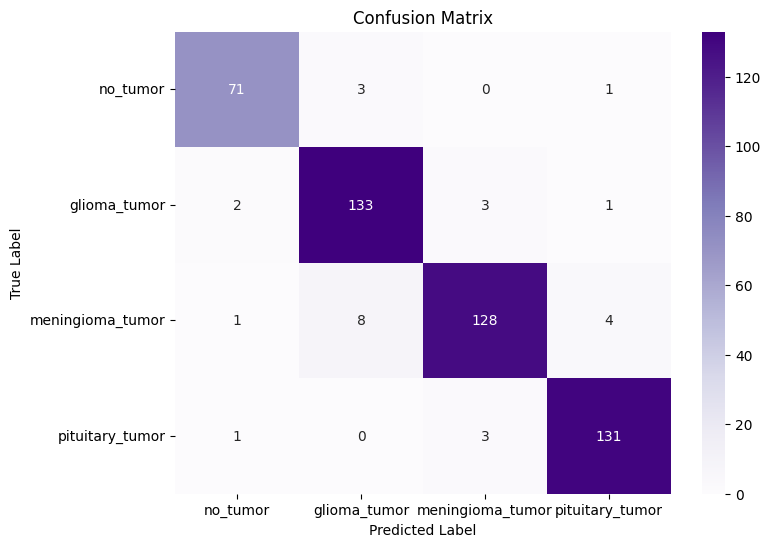

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels_all, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_to_idx.keys(),
            yticklabels=label_to_idx.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model state dictionary loaded successfully.
✅ Preprocessed tensor loaded successfully from /content/drive/MyDrive/Dataset/Preprocessed/meningioma_tumor/Copy of image(2).pt.
Input tensor shape: torch.Size([1, 3, 380, 380])

🔧 FRESH ATTENTION VISUALIZATION SOLUTION LOADED
Now running the attention visualization with INVERTED colormap...
✅ Cleaned all cached modules and memory
🚀 VISUALIZING SEGFORMER ATTENTION
Performing forward pass to capture attention...
✅ Hook captured attention output with shape: torch.Size([1, 144, 256])
✅ Reshaped attention map to a 2D grid with shape: (12, 12)


/tmp/ipython-input-1129865803.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]


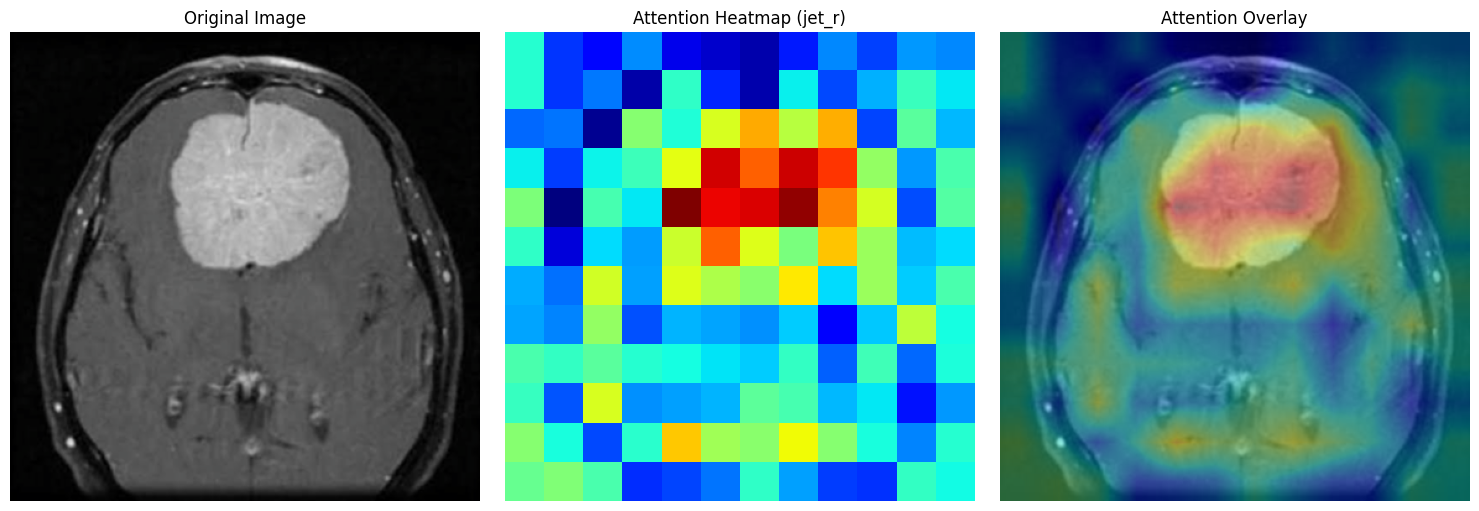

✅ Visualization completed!
Hook removed.


In [ ]:
# Inverted heatmap code jet_r to mimic Grad-Cam visualizations

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import SegformerForImageClassification
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO

# same helper functions

def clean_restart():
    import gc
    import sys

    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("cleaned all cached modules and memory")

def visualize_attention(attention_map, original_image, invert_colormap=False):
    if attention_map is None:
        print("No attention map to visualize")
        return

    try:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image handling
        if isinstance(original_image, torch.Tensor):
            if original_image.dim() == 4:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = original_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
                img_np = std * img_np + mean
            else:
                img_np = original_image.permute(1, 2, 0).cpu().detach().numpy()
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = np.array(original_image)

        axes[0].imshow(img_np)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Select colormap based on invert_colormap flag
        colormap = 'jet_r' if invert_colormap else 'jet'

        # Attention map heatmap
        axes[1].imshow(attention_map, cmap=colormap)
        axes[1].set_title(f'Attention Heatmap ({colormap})')
        axes[1].axis('off')

        # Overlay
        h, w = img_np.shape[:2]
        attn_resized = cv2.resize(attention_map, (w, h), interpolation=cv2.INTER_LINEAR)
        attn_normalized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)

        # Apply the selected colormap to the normalized attention map
        heatmap = plt.cm.get_cmap(colormap)(attn_normalized)[:,:,:3]

        overlay = 0.6 * img_np + 0.4 * heatmap
        overlay = np.clip(overlay, 0, 1)

        axes[2].imshow(overlay)
        axes[2].set_title('Attention Overlay')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print("Visualization completed!")

    except Exception as e:
        print(f"Visualization error: {e}")
        import traceback
        traceback.print_exc()

def visualize_segformer_attention(model, input_tensor, invert_colormap=False):
    print("Visualizing SegFormer attention")

    attention_outputs = []

    last_block_attention_output = model.segformer.encoder.block[3][1].attention.output.dense

    def hook_fn(module, input, output):
        attention_outputs.append(output)

    hook = last_block_attention_output.register_forward_hook(hook_fn)

    try:
        print("Performing forward pass to capture attention...")
        with torch.no_grad():
            _ = model(input_tensor)

        if not attention_outputs:
            print("Hook did not capture any output.")
            return None

        attention_output = attention_outputs[0]

        print(f"Hook captured attention output with shape: {attention_output.shape}")

        attention_output = attention_output.squeeze(0)
        attention_map = attention_output.mean(dim=-1).detach().cpu().numpy()

        num_patches = attention_map.shape[0]
        height = int(np.sqrt(num_patches))
        width = int(np.sqrt(num_patches))
        attention_map_2d = attention_map.reshape(height, width)

        print(f"Reshaped attention map to a 2D grid with shape: {attention_map_2d.shape}")

        # Pass the invert_colormap flag to the visualization function
        visualize_attention(attention_map_2d, input_tensor, invert_colormap=invert_colormap)

        return attention_map_2d

    finally:
        hook.remove()
        print("Hook removed.")

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your fine-tuned model
model = SegformerForImageClassification.from_pretrained(
    'nvidia/segformer-b0-finetuned-ade-512-512',
    num_labels=4
).to(device)

try:
    state_dict = torch.load('/content/drive/MyDrive/Dataset/ViT_MRI_Model.pth', map_location=device)
    model.load_state_dict(state_dict)
    print("Model state dictionary loaded successfully.")
except FileNotFoundError:
    print("Model checkpoint not found. Using pre-trained weights only.")
except Exception as e:
    print(f"Error loading state dictionary: {e}. Using pre-trained weights only.")

model.eval()

# -Load tensor file
image_tensor_path = "/content/drive/MyDrive/Dataset/Preprocessed/meningioma_tumor/Copy of image(2).pt"

try:
    original_tensor = torch.load(image_tensor_path, map_location=device)
    if original_tensor.dim() == 3:
        original_tensor = original_tensor.unsqueeze(0)
    input_tensor = original_tensor
    print(f"Preprocessed tensor loaded successfully from {image_tensor_path}.")
    print(f"Input tensor shape: {input_tensor.shape}")
except FileNotFoundError:
    print(f"Error: Tensor file not found at {image_tensor_path}. Creating a random tensor as fallback.")
    input_tensor = torch.randn(1, 3, 512, 512).to(device)

# --- Run the visualization with the inverted colormap ---
print("\nAttention Heatmap loaded")
print("Now running with jet_r colormap")

clean_restart()
attention_map = visualize_segformer_attention(model, input_tensor, invert_colormap=True)